In [1]:
import pickle
import os
import torch

files = os.listdir("grads")
files = [f for f in files if f not in ['Grads.ipynb', '.ipynb_checkpoints']]
grad_dict = {}
for i, g in enumerate(files):
    with open(f'grads/{g}', 'rb') as file:
        grad = pickle.load(file)

    for name, layer in grad.items():
        if i == 0:
            grad_dict[f'{name}'] = [grad[f'{name}'].unsqueeze(0)]
        else:
            grad_dict[f'{name}'].append(grad[f'{name}'].unsqueeze(0))
            
for name, grad in grad_dict.items():
    grad_dict[f'{name}'] = torch.cat(grad)

In [3]:
import torch
import os
from segmentation_models_pytorch.metrics import get_stats, iou_score
from utils.utils import display_image_and_mask
from utils.data_loading import TomatoLeafDataset
from unet.model import TomatoLeafModel

DIR = "data/"

# Load the dataset
test_loader = TomatoLeafDataset(DIR + "test.csv", DIR + "test")
train_loader = TomatoLeafDataset(DIR + "train.csv", DIR + "train")
image = train_loader[0]['image'].unsqueeze(0)

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def nfm(weight):
    return torch.inner(weight.flatten(start_dim=1), weight.flatten(start_dim=1))

In [4]:
import torch.nn.functional as F

agop_list = []

counter = 0
input_data = image
for _, grad in grad_dict.items():
    if counter == 0:
        weight = nfm(grad.mean(0, keepdim=True).squeeze(0)).unsqueeze(0).repeat(1, 3, 1, 1)

    else:
        weight = nfm(grad.mean(0, keepdim=True).squeeze(0)).unsqueeze(0)

    agop_list.append(weight)

In [11]:
output1 = F.conv2d(image, agop_list[0], stride=agop_list[0].shape[-1]//4, padding=0)

torch.Size([1, 1, 85, 53])
torch.Size([1, 3, 64, 64])


Text(0.5, 1.0, 'AGOP Convolution of Logit Layer')

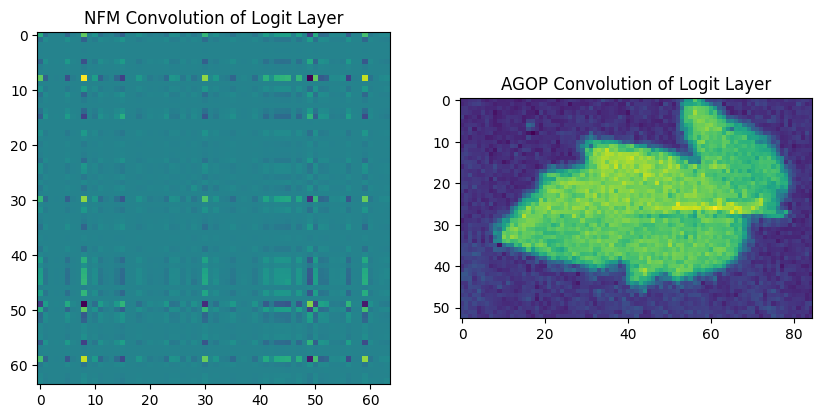

In [13]:
import matplotlib.pyplot as plt

figsize=(10, 6)
plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.imshow(agop_list[0].squeeze(0)[0].detach().numpy().T)
plt.title('NFM Convolution of Logit Layer')

plt.subplot(1, 2, 2)
plt.imshow(output1.squeeze(0).detach().numpy().T)
plt.title('AGOP Convolution of Logit Layer')